# Kalman filter testing

A Jupyter notebook to test my understanding of Kalman filters and apply them to human mobility tracking.

I simulate a time series that follows the models Kalman filter assumes, then use Kalman filter to do prediction and update to check the performance of the filter.

**Fact**: Suppose that the data $\{z_k\}_{k\in\mathbb{N}}$ follows the measurement model and dynamic model below, then the estimates obtained from the Kalman filter is the best linear unbiased estimate. Best in the sense that the estimates achieve minimum variance and are least-squares solutions.

In [3]:
from filters import kalmanWalk
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In the context of geolocation records of a person, we have a set of latitude, longitude measurements of the person at different times $t_k, k=0,1,...$. Let the measurement at time $k$ be $\boldsymbol{z}_k$.

**Measurement model**:
$$\boldsymbol{z}_{k}=\boldsymbol{H}_{k} \boldsymbol{x}_{k}+\boldsymbol{w}_{k} \quad k=0,1,2, \ldots$$
where $\boldsymbol{H}_{k}$ is known and $\boldsymbol{w}_{k}\sim N(\boldsymbol{0},\boldsymbol{R}_k),$ for some positive definite matrix $\boldsymbol{R}_k$.

**Dynamic model**:
$$\boldsymbol{x}_{k+1}=\boldsymbol{\Phi}_{k} \boldsymbol{x}_{k} + \boldsymbol{u}_{k} \quad k=0,1,2, \ldots$$
where $\boldsymbol{\Phi}_{k}$ is known and $\boldsymbol{u}_{k}\sim N(\boldsymbol{0},\boldsymbol{Q}_k),$ for some positive definite matrix $\boldsymbol{Q}_k$.

## Simulation

First, let's try to simulate a 1-dimensional constant velocity model.

First note that $\boldsymbol{x_k} = \begin{bmatrix} x_k\\ v\end{bmatrix}$. So 
$$\boldsymbol{x}_{k+1} 
= \begin{bmatrix} x_k + v\Delta t_k\\ v\end{bmatrix}
= \begin{bmatrix} 
    1 & \Delta t_k\\
    0 & 1
  \end{bmatrix}
\boldsymbol{x}_k.$$ 
Implying $\boldsymbol{\Phi}_k 
= \begin{bmatrix} 
    1 & \Delta t_k\\
    0 & 1
  \end{bmatrix}$

Also, $\boldsymbol{H}_k
= \begin{bmatrix} 
    1 & 0
  \end{bmatrix}$.

In [30]:
x, z, t = kalmanWalk(NUM_POINTS=50)

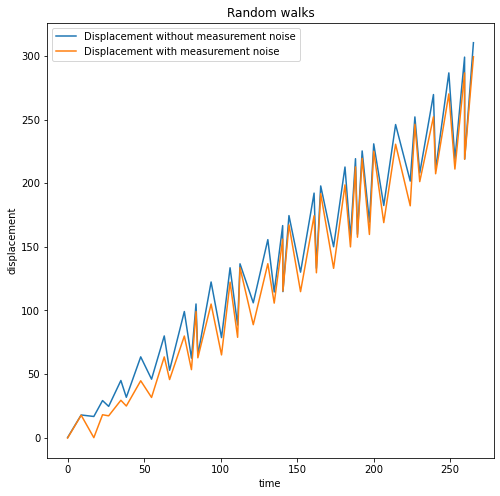

In [31]:
plt.figure(figsize=(8,8))
plt.plot(t, x[:,0])
plt.plot(t, z)
plt.xlabel("time")
plt.ylabel("displacement")
plt.title("Random walks")
plt.legend(["Displacement without measurement noise", "Displacement with measurement noise"])
plt.show()

## Kalman filtering

**Equations for prediction**:

Predicts the next state $\boldsymbol{x}_k$ and next state error covariance matrix $P_{k \mid k-1}$.

Parameters:
- $\Phi_{k-1}$: state transition matrix
- $\hat{x}_{k-1 \mid k-1}$: current state estimate
- $P_{k-1 \mid k-1}$: current state error covariance matrix
- $Q_{k-1}$: process noise covariance matrix

$\hat{x}_{k \mid k-1}=\Phi_{k-1} \hat{x}_{k-1 \mid k-1}$

$P_{k \mid k-1}=\Phi_{k-1} P_{k-1 \mid k-1} \Phi_{k-1}^{T}+Q_{k-1}$

**Equations for update**:

Updates the current state estimate $\hat{x}_{k \mid k}$ and next state error covariance matrix $P_{k \mid k}$.

$\hat{x}_{k \mid k}=\hat{x}_{k \mid k-1}+K_{k}\left(z_{k}-H_{k} \hat{x}_{k \mid k-1}\right)$

$P_{k \mid k}=\left(I-K_{k} H_{k}\right) P_{k \mid k-1}$

$K_{k}=P_{k \mid k-1} H_{k}^{T}\left(R_{k}+H_{k} P_{k \mid k-1} H_{k}^{T}\right)^{-1}$, Kalman gain

In [27]:
def update(P, H, R, z, x):
    '''
    :param P: state error covariance matrix
    :param H: output transition matrix
    :param R: measurement noise covariance matrix
    :param z: new measurement
    :param x: old state estimate
    :return x_new: new state estimate
    :return P: new state error covariance matrix
    '''
    def kalmanGain(P, H, R):
        K = R + np.dot(np.dot(H, P), H.T)

        if type(K) != np.ndarray:
            return np.dot(P, H.T) * (1/K)
        else:
            K = np.dot(np.dot(P, H.T), np.linalg.inv(K))
            return K

    K = kalmanGain(P=P, H=H, R=R)
    x_new = x + np.dot(K, z - np.dot(H, x))
    P_new = np.dot(np.eye(len(P)) - np.dot(K,H), P)
    
    return x_new, P_new

def predict(Phi, x, P, Q):
    '''
    :param Phi: state error covariance
    :param x: current state
    :param P: current state error covariance matrix
    :param Q: process noise covariance matrix
    :return x_pred: prediction of the next state
    :return P_pred: prediction of the next state error covariance matrix
    '''
    x_pred = np.dot(Phi, x)
    P_pred = np.dot(np.dot(Phi,P), Phi.T) + Q
    
    return x_pred, P_pred

In [32]:
N = len(z) # no. of noisy measurements

sigma2_R = 0.1
sigma2_Q = 0.0001

Q = np.array([[0,0], [0,sigma2_Q]]) # process noise
R = sigma2_R # measurement noise

x_est = x[0] # estimate of initial location
P_est = np.array([[sigma2_R,0],[0,sigma2_Q]]) # estimate of initial error covariance
H = np.array([1,0])

In [33]:
x_est_all = np.array([x_est])
P_est_all = np.array([P_est])

for i in range(1, len(t)):
    Phi_i = np.array([[1, t[i]-t[i-1]], [0, 1]])
    x_pred, P_pred = predict(Phi_i, x_est, P_est, Q)
    x_est, P_est = update(P_pred, H, R, z[i], x_pred)
    
    x_est_all = np.concatenate((x_est_all, np.array([x_est])))
    P_est_all = np.concatenate((P_est_all, np.array([P_est])))

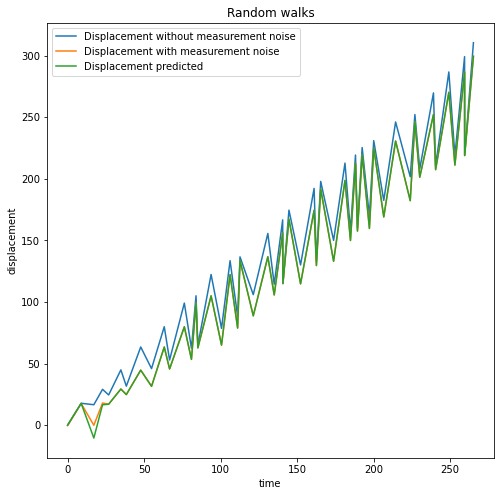

In [34]:
plt.figure(figsize=(8,8))
plt.plot(t, x[:,0])
plt.plot(t, z)
plt.plot(t, x_est_all[:,0])
plt.xlabel("time")
plt.ylabel("displacement")
plt.title("Random walks")
plt.legend(["Displacement without measurement noise", "Displacement with measurement noise", "Displacement predicted"])
plt.show()

## Tests for model diagnostics

- **Test 1:** If the measurement noise is indeed gaussian, $\boldsymbol{z} - \hat{x}$ should fall within the interval $[-2\sqrt{R},2\sqrt{R}]$ 95% of the time.
- **Test 2:** 
- **Test 3:** Innovation whiteness (autocorrelation) test

    Let innovation be defined as the difference between the measurement predictions and actual measurement.

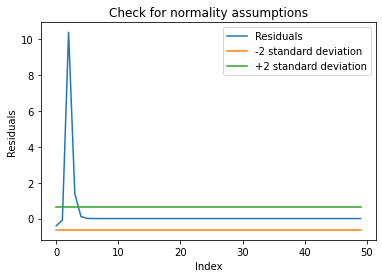

In [60]:
plt.plot([i for i in range(len(z))], z - x_est_all[:,0])
plt.plot([i for i in range(len(z))], [-2*math.sqrt(R)] * len(z))
plt.plot([i for i in range(len(z))], [2*math.sqrt(R)] * len(z))
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Check for normality assumptions")
plt.legend(["Residuals", "-2 standard deviation", "+2 standard deviation"])

plt.show()

## Overestimating measurement noise

Measurement variance was set as `sigma2_R=0.1`.

Let's set `sigma2_R=10` to see the difference.

In [61]:
N = len(z) # no. of noisy measurements

sigma2_R = 10
sigma2_Q = 0.0001

Q = np.array([[0,0], [0,sigma2_Q]]) # process noise
R = sigma2_R # measurement noise

x_est = x[0] # estimate of initial location
P_est = np.array([[sigma2_R,0],[0,sigma2_Q]]) # estimate of initial error covariance
H = np.array([1,0])

x_est_all = np.array([x_est])
P_est_all = np.array([P_est])

for i in range(1, len(t)):
    Phi_i = np.array([[1, t[i]-t[i-1]], [0, 1]])
    x_pred, P_pred = predict(Phi_i, x_est, P_est, Q)
    x_est, P_est = update(P_pred, H, R, z[i], x_pred)
    
    x_est_all = np.concatenate((x_est_all, np.array([x_est])))
    P_est_all = np.concatenate((P_est_all, np.array([P_est])))

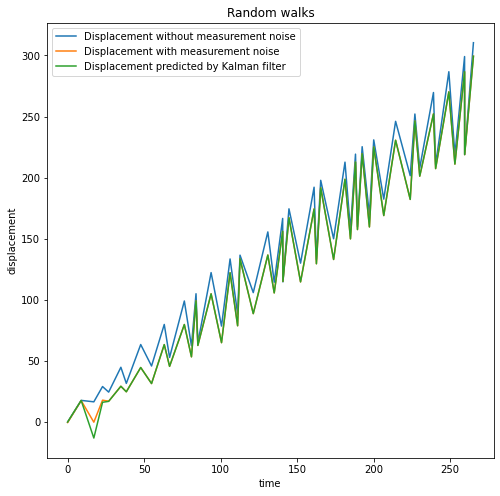

In [63]:
plt.figure(figsize=(8,8))
plt.plot(t, x[:,0])
plt.plot(t, z)
plt.plot(t, x_est_all[:,0])
plt.xlabel("time")
plt.ylabel("displacement")
plt.title("Random walks")
plt.legend(["Displacement without measurement noise", "Displacement with measurement noise",
            "Displacement predicted by Kalman filter"])
plt.show()